# Lab #2

Today's lab consists of practice questions to review MLPs and convolutional neural networks.

## Question 1
### Classifying newswires: a multi-class classification example
In this example we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Examples include cocoa, soybeans and livestock. Since we have many classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

### The Reuters dataset
We will be working with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look:

In [0]:
# Load all necessary libraries
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
!pip install tensorflow-hub
!pip install tfds-nightly
import tensorflow_hub as hub
import numpy as np
import keras
import pandas as pd
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the data.

We have 8,982 training examples and 2,246 test examples:

In [0]:
len(train_data)

8982

In [0]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [0]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [0]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [0]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [0]:
train_labels[10]

3

### Preparing the data
We can vectorize the data with the exact same code as in our previous example:

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1 in [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python). In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [0]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### Building our network
This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the dimensionality of the output space is much larger.

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information. For this reason we will use larger layers. 

Build a networks with 2 hidden layers, each with 64 hidden units, and an appropriate output layer. Remember to include the correct `input_shape` in the first hidden layer.

In [0]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(46, activation='softmax')
])

Code the `model.compile` function with `rmsprop` optimizer, `accuracy` performance metric and appropriate loss function.

In [0]:
# Define how to execute training
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Validating our approach
Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Train the network for 20 epochs with a batch size of 512. Be sure to make use of the validation set.

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 55ms/step - loss: 2.5583 - accuracy: 0.5149 - val_loss: 1.7136 - val_accuracy: 0.6320
Epoch 2/20
16/16 [==============================] - 1s 44ms/step - loss: 1.4080 - accuracy: 0.7106 - val_loss: 1.3336 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 1s 46ms/step - loss: 1.0688 - accuracy: 0.7701 - val_loss: 1.1490 - val_accuracy: 0.7560
Epoch 4/20
16/16 [==============================] - 1s 45ms/step - loss: 0.8460 - accuracy: 0.8198 - val_loss: 1.0490 - val_accuracy: 0.7690
Epoch 5/20
16/16 [==============================] - 1s 47ms/step - loss: 0.6798 - accuracy: 0.8547 - val_loss: 0.9865 - val_accuracy: 0.7890
Epoch 6/20
16/16 [==============================] - 1s 47ms/step - loss: 0.5401 - accuracy: 0.8857 - val_loss: 0.9377 - val_accuracy: 0.7990
Epoch 7/20
16/16 [==============================] - 1s 45ms/step - loss: 0.4402 - accuracy: 0.9082 - val_loss: 0.9156 - val_accuracy: 0.8060
Epoch 8/20
16


Display its loss and accuracy curves.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

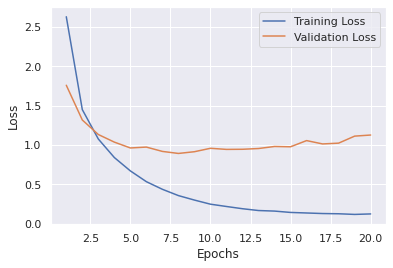

In [0]:
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

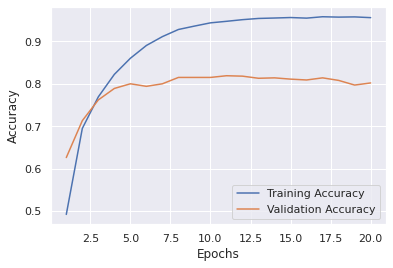

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

It seems that the network starts overfitting after 8 epochs. Train a new network from scratch for 8 epochs, then evaluate it on the test set.

In [0]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 [==============================] - 1s 49ms/step - loss: 2.7214 - accuracy: 0.5243 - val_loss: 1.8073 - val_accuracy: 0.6240
Epoch 2/8
16/16 [==============================] - 1s 46ms/step - loss: 1.4579 - accuracy: 0.7053 - val_loss: 1.3135 - val_accuracy: 0.7080
Epoch 3/8
16/16 [==============================] - 1s 45ms/step - loss: 1.0653 - accuracy: 0.7771 - val_loss: 1.1336 - val_accuracy: 0.7530
Epoch 4/8
16/16 [==============================] - 1s 42ms/step - loss: 0.8357 - accuracy: 0.8230 - val_loss: 1.0235 - val_accuracy: 0.7940
Epoch 5/8
16/16 [==============================] - 1s 41ms/step - loss: 0.6669 - accuracy: 0.8622 - val_loss: 0.9624 - val_accuracy: 0.8060
Epoch 6/8
16/16 [==============================] - 1s 42ms/step - loss: 0.5323 - accuracy: 0.8893 - val_loss: 0.9345 - val_accuracy: 0.7990
Epoch 7/8
16/16 [==============================] - 1s 41ms/step - loss: 0.4293 - accuracy: 0.9122 - val_loss: 0.8949 - val_accuracy: 0.8160
Epoch 8/8
71/71 [===

In [0]:
results

[0.9907603859901428, 0.7898486256599426]

Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [0]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.18432769367764915

### On the importance of having sufficiently large intermediate layers
We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden units. See what happens when you introduce an information bottleneck by setting the number of nodes in the second hidden layer to 4.

In [0]:
# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation = 'relu', input_shape=(10000,)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=512,
          validation_data=(x_val, y_val))

Epoch 1/20
13/16 [=======================>......] - ETA: 0s - loss: 3.6169 - accuracy: 0.0176

Our network now seems to peak at ~66% test accuracy, a 12% absolute drop. This drop is mostly due to the fact that we are now trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram most of the necessary information into these 8-dimensional representations, but not all of it.

### Further experiments
1. Try using larger or smaller layers: 32 units, 128 units...
2. We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.